In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import math

# 前言
驻扎优矿的时间可以说并不久，不过结合着实际操作，已经在社区里学到了不少新东西（比如机器学习方面，大神好多！）。一直也希望能够把自己的知识共享出去，为社区补充一些东西，前段时间恰好读到了 @fyiqi 写的“金融时间序列分析入门（一）（四）”，觉得其深入浅出地介绍一些理论知识的模式比较合适，因为确实一些基础且实用的理论在社区内还没被介绍过。比如卡尔曼滤波，在社区里几乎没有对它的介绍与算法实现，因此在本贴中希望能够在一定程度上将其补充~

P.S. 本贴一定程度上可以看作对 @fyiqi 的“金融时间序列分析入门（一）~（四）”的补充，会用到其中的一些概念（如ARMA模型）
>https://uqer.datayes.com/v3/community/share/58221fb8228e5ba8f857197f

In [2]:
# data preparing
BCHAIN = pd.read_csv('BCHAIN-MKPRU.csv', header=0)
GOLD = pd.read_csv('LBMA-GOLD.csv', header=0)
# to datetime
BCHAIN.Date = pd.to_datetime(BCHAIN.Date)
GOLD.Date = pd.to_datetime(GOLD.Date)
# merge
df = pd.merge(BCHAIN, GOLD, how='inner',on='Date')
df.columns = ['Date', 'BCHAIN', 'GOLD']
df = df.set_index('Date').rename_axis('Asset', axis=1)
# before fill
df.GOLD = df.GOLD.fillna(method="ffill")
df = df.dropna()


<AxesSubplot:xlabel='Date'>

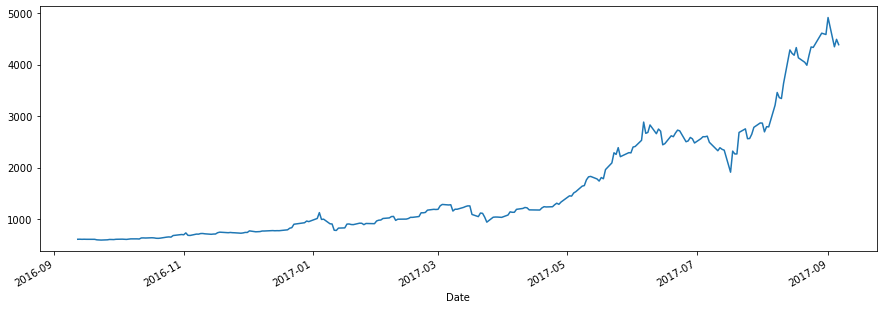

In [3]:

#提取BCHAIN
price_1d = df.BCHAIN[0:250]
price_1d.plot(figsize = (15,5))

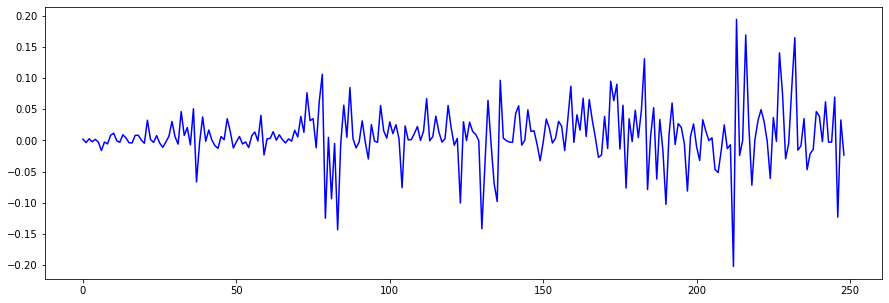

In [4]:
#求对数收益率（y_t）
log_data = np.log(price_1d)
log_return = np.array(log_data.diff()[1:])
plt.figure(figsize=(15,5))
plt.plot(log_return,'b-',label = 'log_return')

In [5]:
#ARMA模型：通过信息准则定阶（详细解读参照“金融时间序列入门（一）”[https://uqer.io/community/share/5790a091228e5b90cda2e2ea]）
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

order = sm.tsa.arma_order_select_ic(log_return,max_ar=3,max_ma=2,ic=['aic','bic','hqic']) #定阶
print('aic-order: ',order.aic_min_order)
print('bic-order: ',order.bic_min_order)
print('hqic-order: ',order.hqic_min_order)

C:\Users\Alephant\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Alephant\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_mo

aic-order:  (0, 1)
bic-order:  (0, 0)
hqic-order:  (0, 0)


C:\Users\Alephant\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [6]:
#bic与hqic均给出ar阶数为2，又根据前面假设：p >= q+1，故令order = (2,1)
order = (2,1)
model = sm.tsa.ARMA(log_return,order).fit()

C:\Users\Alephant\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [7]:
#ljung-box检验（检验残差序列是否存在滞后相关）
r,q,p = sm.tsa.acf(model.resid, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.000840   0.000178  0.989365
2.0  -0.002164   0.001362  0.999319
3.0   0.013488   0.047580  0.997279
4.0   0.021858   0.169457  0.996607
5.0  -0.031388   0.421818  0.994707
6.0  -0.013541   0.468978  0.998196
7.0   0.029469   0.693251  0.998387
8.0  -0.060155   1.631668  0.990300
9.0  -0.021406   1.750994  0.994822
10.0  0.048306   2.361202  0.992748
11.0  0.058719   3.266631  0.986712
12.0  0.078506   4.891922  0.961492
13.0  0.029324   5.119646  0.972464
14.0  0.010404   5.148433  0.983638
15.0 -0.034291   5.462496  0.987433
16.0 -0.060210   6.434913  0.982680
17.0  0.014246   6.489589  0.989245
18.0  0.005805   6.498707  0.993717
19.0 -0.015332   6.562582  0.996206
20.0 -0.065673   7.739668  0.993455
21.0 -0.040148   8.181515  0.994326
22.0  0.085376  10.188385  0.984515
23.0 -0.041478  10.664154  0.986360
24.0 -0.032291  10.953790  0.989338
25.0 -0.042074  11.447703  0.990480
26.0 -0.085138  13.479197  0

C:\Users\Alephant\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\Alephant\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [8]:
print(model.summary())
print('------------------------------------------------')
print('params: ',model.params)      #ARMA模型得到的参数
print('pvalues: ',model.pvalues)    #ARMA模型得到的参数的p-value。下面的程序中，将p-value > 0.05（即不显著）的参数忽略。

#得到观测值y（满足均值为0的ARMA过程）
y = np.zeros(len(log_return))
if model.pvalues[0] < 0.05:
    y = np.array(log_return - model.params[0])      #如果拟合的ARMA模型中常数项显著不为0，则将其减去
else:
    y = np.array(log_return)
    

#T矩阵
T = np.zeros((order[0],order[0]))
phi = []
for i in range(1,order[0]+1):
    if model.pvalues[i] < 0.05:
        phi.append(model.params[i])     #将p-value > 0.05（即不显著）的参数忽略
    else:
        phi.append(0)

T[:,0] = phi     #得到T矩阵第一列
for i in range(1,order[0]):
    T[i-1,i] = 1
T = np.mat(T)    #得到T矩阵
print('T: ',T)

#R矩阵
R = np.zeros((order[0],1))
R[0] = 1
for i in range(order[0]+1,len(model.params)):
    if model.pvalues[i] < 0.05:
        R[i - order[0]] = model.params[i]
R = np.mat(R)
print('R: ',R)    #得到R矩阵
theta = R[1:]

#Z矩阵
Z = np.zeros(order[0])
Z[0] = 1
Z = np.mat(Z)     #得到Z矩阵
print('Z: ',Z)

#得到Q
Q = math.sqrt(model.sigma2)
print('Q: ',Q)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  249
Model:                     ARMA(2, 1)   Log Likelihood                 416.723
Method:                       css-mle   S.D. of innovations              0.045
Date:                Sun, 20 Feb 2022   AIC                           -823.446
Time:                        09:11:26   BIC                           -805.859
Sample:                             0   HQIC                          -816.367
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.003      3.070      0.002       0.003       0.013
ar.L1.y       -0.9713      0.178     -5.454      0.000      -1.320      -0.622
ar.L2.y       -0.1238      0.064     -1.939      0.0

In [10]:
#得到初始化的sigma矩阵
a = Q * np.random.randn(len(y))        #标准差为Q的白噪声序列
s = np.zeros((len(y) - order[0],1))    #需要用到t-m时间的数值，故忽略前m个时间
s = y[order[0]:]
for i in range(1,order[0]):
    ar = np.zeros((len(y) - order[0],1))
    ma = np.zeros((len(y) - order[0],1))
    for j in range(i,order[0]):
        ar = ar + (phi[j] * y[order[0] + i - (j+1): len(y) + i - (j+1)]).reshape(len(y)-order[0],1)
        ma = ma + (theta[j-1] * a[order[0] + i - j: len(a) + i - j]).reshape(len(y)-order[0],1)
    
    s = np.hstack([s,(ar+np.array(ma)).flatten()])
sigma = np.cov(s, s.T)
# sigma = np.mat(sigma)
print('sigma: ',sigma)

sigma:  [[0.00185971 0.00185971]
 [0.00185971 0.00185971]]


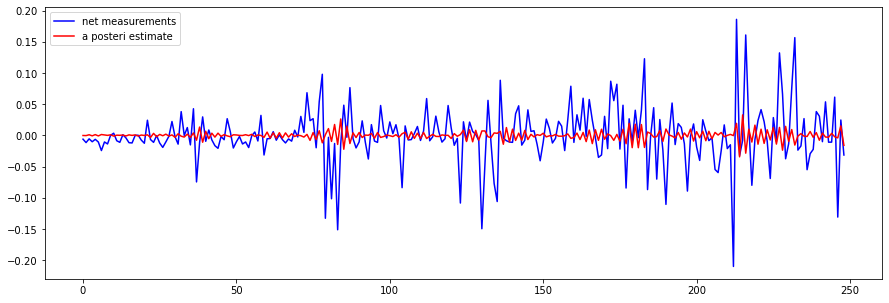

In [11]:
#kalman
#初始化
v = np.zeros(len(y))
xhat = np.mat(np.zeros((order[0],1)))
#迭代过程
for t in range(1,len(y)):
    v[t] = y[t-1] - Z * xhat[:,t-1]
    V = Z * sigma * Z.T
    K = T * sigma * Z.T * np.linalg.inv(V)
    L = T - K * Z
    xhat = np.hstack([xhat,T * xhat[:,t-1] + K * v[t]])
    sigma = T * sigma * L.T + R * Q * R.T

plt.figure(figsize=(15,5))
plt.plot(y,'b-',label = 'net measurements')     #测量值
plt.plot(xhat.getA()[0],'r-',label = 'a posteri estimate')   #过滤后的值
plt.legend()

In [12]:
#预测收益率一步涨跌准确率——ARMA + Kalman
count = 0
for i in range(len(y)):
    if (y[i]-y[i-1] > 0 and xhat.getA()[0][i]-xhat.getA()[0][i-1] > 0) or (y[i]-y[i-1] < 0 and xhat.getA()[0][i]-xhat.getA()[0][i-1] < 0):
        count = count + 1
rate = float(count) / len(y)
print(rate)

0.570281124497992


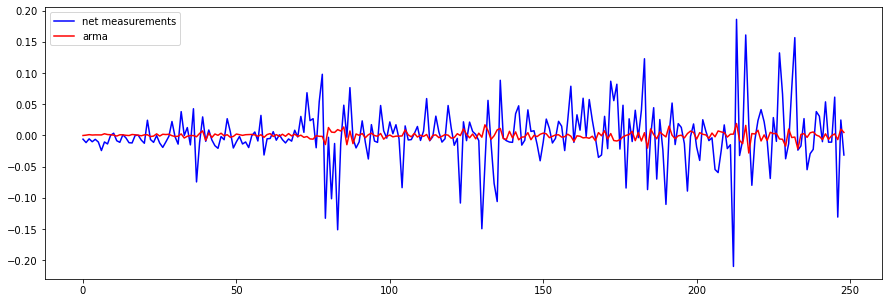

In [13]:
plt.figure(figsize=(15,5))
plt.plot(y,'b-',label = 'net measurements')     #测量值
plt.plot(model.fittedvalues - model.params[0],'r-',label = 'arma')  #ARMA拟合值
plt.legend()

In [14]:
#预测收益率一步涨跌准确率——ARMA
count = 0
for i in range(len(y)):
    if (y[i]-y[i-1] > 0 and model.fittedvalues[i]-model.fittedvalues[i-1] > 0) or (y[i]-y[i-1] < 0 and model.fittedvalues[i]-model.fittedvalues[i-1] < 0):
        count = count + 1
rate = float(count) / len(y)
print(rate)

0.6224899598393574


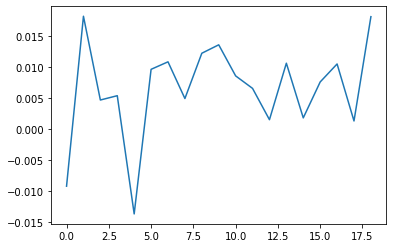

In [46]:
plt.plot(model.predict()[-20:-1])

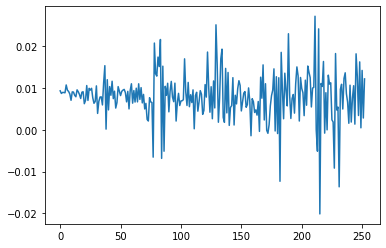

In [57]:
plt.plot(model.predict(start=2 , end=249+5, dynamic=False))